In [3]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

# Univariate Gaussian

In [4]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

loc = 5
scale = 20
data = torch.tensor(np.random.normal(loc=loc, scale=scale, size=1000))

loc = 5
scale = 20
data = torch.tensor(np.random.normal(loc=loc, scale=scale, size=1000))

def model(loc_prior_params, scale_prior_params, data):
    loc = pyro.sample("loc", dist.Normal(loc_prior_params[0], loc_prior_params[1]))
    scale = pyro.sample("scale", dist.Gamma(scale_prior_params[0], scale_prior_params[1]))
    with pyro.plate("data", 1000):
        return pyro.sample("obs", dist.Normal(loc, scale), obs=data)

# pyro.render_model(model, model_args=([0.,4.], [1., 8.], data), render_params=True, render_distributions=True)

In [5]:
def parametrised_guide(loc_prior_params, scale_prior_params, data):
    mu_mu = pyro.param("mu_mu", torch.tensor(float(loc_prior_params[0])))
    
    mu_std = pyro.param(
        "mu_std", torch.tensor(float(loc_prior_params[1])), constraint=constraints.positive
    )
    
    std_a = pyro.param(
        "std_a", torch.tensor(scale_prior_params[0]), constraint=constraints.positive
    )
    
    std_b = pyro.param(
        "std_b", torch.tensor(scale_prior_params[1]), constraint=constraints.positive
    )

    loc = pyro.sample("loc", dist.Normal(mu_mu, mu_std))
    scale = pyro.sample("scale", dist.Normal(std_a, std_b))
    return pyro.sample("data_dist", dist.Normal(loc, scale))

### Train

C:\Users\ryant\anaconda3\lib\site-packages\pyro\util.py:291: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'data_dist'}
  guide_vars - aux_vars - model_vars
Elbo loss: 6142.452677633746
Elbo loss: 4472.90082233172
Elbo loss: 4470.2476628203485
Elbo loss: 4450.270240564545
Elbo loss: 4450.7917282296585
Elbo loss: 4449.99141985989
Elbo loss: 4450.02951936009
Elbo loss: 4450.813327689761
Elbo loss: 4452.039200870926
Elbo loss: 4450.092685545786


Wall time: 4.16 s


Text(0, 0.5, 'ELBO loss')

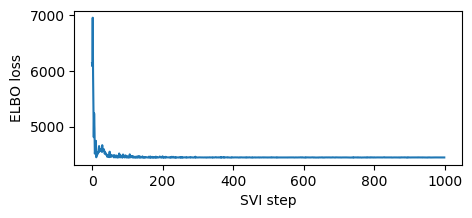

In [6]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
svi = pyro.infer.SVI(
    model=model,
    guide=parametrised_guide,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step([0,10], [8, 1], data)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [7]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

mu_mu 5.5637116
mu_std 0.69525486
std_a 20.262835
std_b 0.45077208


### Multivariate Gaussian
#### Generalise the above the above code to be for a multivariate normal

Let's set up the generative process and know what we're looking for 

$$P(\boldsymbol{x|\mu, \Sigma}) \sim N(\boldsymbol{\mu, \Sigma})$$


$$P(\boldsymbol{\mu}) \sim N(\boldsymbol{\mu_{0}, \Sigma_{0}})$$


Then we generate $\boldsymbol{x_{1}, \ldots, x_{n}}$, and we want to find $P(\boldsymbol{\mu} | \boldsymbol{x_{1}, \ldots, x_{n}}) = N(\boldsymbol{\mu_{n}, \Sigma_{n}})$, where specifically 

$$\boldsymbol{\Sigma_{n}} = \boldsymbol{\Sigma_{0}} \left (\boldsymbol{\Sigma_{0}} + \frac{1}{n} \boldsymbol{\Sigma} \right)^{-1} \frac{1}{n} \boldsymbol{\Sigma}$$

$$\boldsymbol{\mu_{n}} = \boldsymbol{\Sigma_{0}} \left (\boldsymbol{\Sigma_{0}} + \frac{1}{n} \boldsymbol{\Sigma} \right)^{-1} \left (\frac{1}{n} \sum_{i=1}^{n} \boldsymbol{x_{i}} \right) + \frac{1}{n}\boldsymbol{\Sigma}\left (\boldsymbol{\Sigma_{0}} + \frac{1}{n} \boldsymbol{\Sigma} \right)^{-1} \boldsymbol{\mu_{0}}$$

In [82]:
# write a function to find this exact posterior 

def get_posterior_cov_mv_gaussian(n, sigma, sigma_0):
    sum_part = sigma_0 + 1/n * sigma
    sum_part = np.linalg.inv(sum_part)
    p1 = np.matmul(sigma_0, sum_part)
    p2 = np.matmul(p1, 1/n * sigma)
    return(p2)

def get_posterior_mean_mv_gaussian(n, sigma, sigma_0, mu_0, data):
    sum_part = sigma_0 + 1/n * sigma
    sum_part = np.linalg.inv(sum_part)
    
    middle_part = data.mean(axis=0)
    
    p1 = np.matmul(sigma_0, sum_part)
    p2 = np.matmul(p1, middle_part)
    
    p3 = np.matmul(1/n * sigma, sum_part)
    p4 = np.matmul(p3, mu_0)
    return(p2 + p4)
    

In [72]:
# make a function to generate multivariate random data 

def multivar_random(size, normal_params, gamma_params, num_samples):   

    # simulate two random covariance matrices (PSD) for sigma and sigma_0
    mat = np.random.gamma(gamma_params[0], gamma_params[1], size=size**2).reshape((size, size))
    sigma_mat = torch.tensor(np.dot(mat, mat.transpose()))
    
    mat_0 = np.random.gamma(gamma_params[2], gamma_params[3], size=size**2).reshape((size, size))
    sigma_mat_0 = torch.tensor(np.dot(mat_0, mat_0.transpose()))
    
    # simulate some random means
    mu_vector = torch.tensor(np.random.multivariate_normal(normal_params, sigma_mat_0, size=1))[0]
    print(mu_vector)

    # now simulate multivariate gaussian
    data = torch.tensor(np.random.multivariate_normal(mu_vector, sigma_mat, size=num_samples))
    
    return(data, mu_vector, sigma_mat, sigma_mat_0)


In [73]:
# define the model:

def model(loc_mean_prior_params, loc_scale_prior_params, data):
    loc = pyro.sample("loc", dist.MultivariateNormal(loc_mean_prior_params, loc_scale_prior_params))
    # for now leave the scale as the identity - can change it to Wishart in the future
    scale = pyro.param("scale", torch.eye(5, 5))
    with pyro.plate("data", 1000):
        return pyro.sample("obs", dist.MultivariateNormal(loc, scale), obs=data)

In [74]:
def parametrised_guide(loc_mean_prior_params, loc_scale_prior_params, data):
    
    mu_mu = pyro.param("mu_mu", torch.tensor(loc_mean_prior_params))
    
    mu_std = pyro.param(
        "mu_std", torch.tensor(loc_scale_prior_params) , constraint=constraints.positive_definite
    ) 

    loc = pyro.sample("loc", dist.MultivariateNormal(mu_mu, mu_std))
    scale = pyro.param("scale", torch.eye(5, 5))
    return pyro.sample("data_dist", dist.MultivariateNormal(loc, scale))

In [81]:
data.mean(axis=0).shape

torch.Size([5])

C:\Users\ryant\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ryant\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
Elbo loss: 37569.04058647156


tensor([ 2.9335, -3.3431, -1.3363, -3.1334,  0.0773], dtype=torch.float64)


Elbo loss: 9441.631656169891
Elbo loss: 8982.988881111145
Elbo loss: 8913.52305841446
Elbo loss: 8837.711171150208
Elbo loss: 8812.102840900421
Elbo loss: 8818.503715515137
Elbo loss: 8788.621195793152
Elbo loss: 8888.056809425354
Elbo loss: 9090.503962993622


Wall time: 6.47 s


Text(0, 0.5, 'ELBO loss')

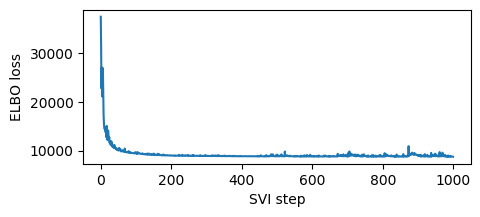

In [76]:
%%time
pyro.clear_param_store()

data, mu_vector, sigma, sigma_0 = multivar_random(5, [0] * 5, [1, 1, 1, 1], 1000)

# These should be reset each training loop.
svi = pyro.infer.SVI(
    model=model,
    guide=parametrised_guide,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(torch.zeros(5), torch.eye(5, 5), data)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [84]:
pyro.get_param_store().items()

<generator object ParamStoreDict.items at 0x000001E9DE9C21C8>

In [85]:
for name, value in pyro.get_param_store().items():
    if name == 'mu_mu' or name == 'mu_std':
        print(name, pyro.param(name).data.cpu().numpy())

mu_mu [ 2.882741   -3.3741767  -1.372194   -3.2502463   0.09272282]
mu_std [[ 0.00342333  0.00390107  0.00033841  0.00553106  0.00555837]
 [ 0.00390107  0.00818106  0.00117048  0.0037125   0.01026615]
 [ 0.00033841  0.00117048  0.00349503 -0.00069344 -0.00377735]
 [ 0.00553106  0.0037125  -0.00069344  0.01188624  0.00821848]
 [ 0.00555837  0.01026615 -0.00377735  0.00821848  0.02388631]]


In [86]:
get_posterior_mean_mv_gaussian(1000, sigma, sigma_0, mu_vector, data)

tensor([ 2.8531, -3.3495, -1.4188, -3.2231,  0.0823], dtype=torch.float64)

In [87]:
get_posterior_cov_mv_gaussian(1000, sigma, sigma_0)

tensor([[0.0046, 0.0042, 0.0033, 0.0052, 0.0045],
        [0.0042, 0.0056, 0.0025, 0.0048, 0.0042],
        [0.0033, 0.0025, 0.0056, 0.0058, 0.0028],
        [0.0052, 0.0048, 0.0058, 0.0079, 0.0045],
        [0.0045, 0.0042, 0.0028, 0.0045, 0.0058]], dtype=torch.float64)

### Bayesian Linear Regression

Same pattern of simulating data and then running SVI on it 

First, set up the specifics of our model:

$$\boldsymbol{y}|\boldsymbol{\beta, \Sigma} \sim N(\boldsymbol{\beta^{T} X}, \sigma^{2} \boldsymbol{I})$$

where $\boldsymbol{\beta}$ has some prior distribution:

$$\boldsymbol{\beta} \sim N(\boldsymbol{\mu_{0}}, \boldsymbol{\Sigma_{0}})$$

and $\sigma$ has some prior

$$\sigma \sim Exp(\lambda)$$. 

Explicity, this is 

$$y_{i} = \beta_{0} + \beta_{1}x_{1i} + \ldots + \beta_{k}x_{ki} + \epsilon_{i}$$

and we assume i.i.d. errors with a mean of zero and some variance: 



$$ \boldsymbol{\epsilon} \sim N(0, \sigma^{2} \boldsymbol{I})$$

No closed form for the true posterior, so we'll have to do this through MCMC

In [267]:
# generate the random data in a linear model

def bayesian_regression_generator(num_estimators, beta_means, noise, num_samples):
    
    # get iid betas for now (normal prior)
    beta_vector = torch.tensor(np.random.normal(5, 1, size = (num_estimators + 1)))

    # big X design matrix
    X_rand = torch.tensor(np.random.multivariate_normal(torch.zeros(num_estimators),
                                                   torch.eye(num_estimators, num_estimators),
                                                   size = 1000))
    X = torch.ones(1000, num_estimators + 1)
    X[:, 1:] = X_rand
    
    sigma = torch.tensor(np.random.exponential(noise))

    # some noise
    epsilon = torch.tensor(np.random.normal(0, sigma, size = 1000))

    # now observations
    y = np.matmul(beta_vector, np.transpose(X)) + epsilon
    
    return(X, y, beta_vector, sigma)

In [268]:
# now that we have data, set up the pyro models and SVI

# define the model:
def model(beta_prior_locs, beta_prior_scale, sigma_prior_rate, X, y):
    
    # we essentially have a multivariate gaussian within for the beta vector:
    beta = pyro.sample("beta", dist.MultivariateNormal(beta_prior_locs, beta_prior_scale))
    
    mu = torch.matmul(beta, np.transpose(X))
    # now the variance
    sigma = pyro.sample("sigma", dist.Exponential(sigma_prior_rate))
    
    with pyro.plate("data", 1000):
        return pyro.sample("obs", dist.Normal(mu, sigma), obs=y)


In [269]:
def parametrised_guide(beta_prior_locs, beta_prior_scale, sigma_prior_rate, X, y):
    
    beta_loc = pyro.param("beta_loc", torch.tensor(beta_prior_locs))
    
    sigma_rate = pyro.param(
        "noise", torch.tensor(sigma_prior_rate) , constraint=constraints.positive
    ) 
    
    beta = pyro.sample("beta", dist.MultivariateNormal(beta_loc, beta_prior_scale))
    sigma = pyro.sample("sigma", dist.Exponential(sigma_rate))
    
    mu = torch.matmul(beta, np.transpose(X))

    return {"beta": beta, "sigma": sigma}

In [270]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

Elbo loss: 55887.21176354913
Elbo loss: 3278.942157596153
Elbo loss: 2990.3223602920334
Elbo loss: 2466.4105236599707
Elbo loss: 1768.373885886567
Elbo loss: 1524.8402902028351
Elbo loss: 1522.59282570833
Elbo loss: 1521.3842265405267
Elbo loss: 1529.5125807617296
Elbo loss: 1521.3229747131852


Wall time: 4.98 s


Text(0, 0.5, 'ELBO loss')

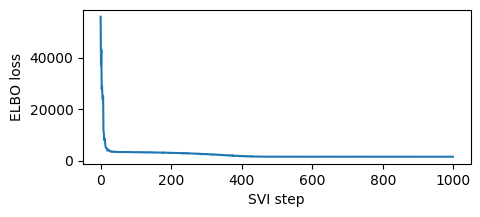

In [273]:
%%time
pyro.clear_param_store()

X, y, beta_vector, sigma = bayesian_regression_generator(num_estimators=3,
                                                         beta_means=torch.zeros(4),
                                                         noise=3,
                                                         num_samples=1000)

# These should be reset each training loop.
svi = pyro.infer.SVI(
    model=model,
    guide=auto_guide,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(torch.zeros(4), torch.eye(4, 4), 1, X, y)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [274]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.beta [5.691011  5.5843663 4.819916  6.2293434]
AutoNormal.scales.beta [0.03649952 0.03113776 0.03577652 0.03128989]
AutoNormal.locs.sigma 0.020515498
AutoNormal.scales.sigma 0.044033676


In [275]:
beta_vector

tensor([5.7219, 5.5588, 4.7766, 6.2026], dtype=torch.float64)